In [3]:
import numpy as np
import qutip as qt 
from ECD_control import BatchOptimizer
from ECD_control.ECD_optimization import OptimizationAnalysis, OptimizationSweepsAnalysis
from ECD_control.ECD_pulse_construction import *
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17280035210186599378]

In [4]:
#The target oscillator state.
N =40
Fock = 3
psi_t = qt.basis(N,3) #target state

In [5]:
#Optimization of ECD Circuit parameters (betas, phis, and thetas)
#the optimization options
opt_params = {
'N_blocks' : 7, #circuit depth
'N_multistart' : 200, #Batch size (number of circuit optimizations to run in parallel)
'epochs' : 200, #number of epochs before termination
'epoch_size' : 10, #number of adam steps per epoch
'learning_rate' : 0.01, #adam learning rate
'term_fid' : 0.995, #terminal fidelitiy
'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
'beta_scale' : 3.0, #maximum |beta| for random initialization
'initial_states' : [qt.tensor(qt.basis(2,0),qt.basis(N,0))], #qubit tensor oscillator, start in |g> |0>
'target_states' : [qt.tensor(qt.basis(2,1), psi_t)], #end in |e> |target>.
'name' : 'Fock %d' % Fock, #name for printing and saving
'filename' : None, #if no filename specified, results will be saved in this folder under 'name.h5'
}
#note: optimizer includes pi pulse in every ECD step. However, final ECD step is implemented 
#in experiment as a displacement since the qubit and oscillator should be disentangled at this point.
#So, we ask the optimizer to end in |e> |target> instead of |g>|target>.

In [6]:
#create optimization object. 
#initial params will be randomized upon creation
opt = BatchOptimizer(**opt_params)

#print optimization info. 
opt.print_info()

optimization_type: state transfer
N_multistart: 200
N_blocks: 7
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 1.0
theta_scale: 3.141592653589793
use_etas: False
use_displacements: False
use_phase: False
name: Fock 3
comment: 
N_cav: 40
filename: Fock 3.h5

Best circuit parameters found:
betas:         [ 1.886  -0.22746j  0.23952-0.40298j  2.81271-0.41544j -0.85161-0.70382j
  0.6044 +0.22443j -0.72426-0.66777j  1.4966 +0.11162j]
alphas:        [0.+0.j]
phis (deg):    [   0.      -175.66798  179.23268   83.69862   11.54861  -12.80236
  -16.84502]
etas (deg):    [89.99999 89.99999 89.99999 89.99999 89.99999 89.99999 89.99999]
thetas (deg):  [ 177.35602  109.21643  -89.83287  -36.32763  169.29726  -79.75266
 -106.31186]
Max Fidelity:  0.173811




In [7]:
#run optimizer.
#note the optimizer can be stopped at any time by interrupting the python consle,
#and the optimization results will still be saved and part of the opt object.
#This allows you to stop the optimization whenever you want and still use the result.
opt.optimize()

Start time: 2022-02-14 13:55:48
 Epoch: 21 / 200 Max Fid: 0.996331 Avg Fid: 0.823912 Max dFid: 0.045447 Avg dFid: 0.005237 Elapsed time: 0:02:23.385654 Remaing time: 0:20:22.192003

 Optimization stopped. Term fidelity reached.

optimization_type: state transfer
N_multistart: 200
N_blocks: 7
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 1.0
theta_scale: 3.141592653589793
use_etas: False
use_displacements: False
use_phase: False
name: Fock 3
comment: 
N_cav: 40
filename: Fock 3.h5

Best circuit parameters found:
betas:         [-1.76334+1.26888j  0.54475+0.95636j  0.8697 +0.54226j  0.40844+0.66937j
  0.51122+1.15909j  0.41895-0.09396j -0.02548-0.01854j]
alphas:        [0.+0.j]
phis (deg):    [  0.      -86.41734  81.2397  101.19695  78.68073 -72.43673 162.7951 ]
etas (deg):    [89.99999 89.99999 89.99999 89.99999 89.99999 89.99999 89.99999]
thetas (deg):  [ 90.24229 -79.23735 125.4025   42.69864  72.76336 -7

'2022-02-14 13:55:48'

In [8]:
#can print info, including the best circuit found.
opt.print_info() 

optimization_type: state transfer
N_multistart: 200
N_blocks: 7
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 1.0
theta_scale: 3.141592653589793
use_etas: False
use_displacements: False
use_phase: False
name: Fock 3
comment: 
N_cav: 40
filename: Fock 3.h5

Best circuit parameters found:
betas:         [-1.76334+1.26888j  0.54475+0.95636j  0.8697 +0.54226j  0.40844+0.66937j
  0.51122+1.15909j  0.41895-0.09396j -0.02548-0.01854j]
alphas:        [0.+0.j]
phis (deg):    [  0.      -86.41734  81.2397  101.19695  78.68073 -72.43673 162.7951 ]
etas (deg):    [89.99999 89.99999 89.99999 89.99999 89.99999 89.99999 89.99999]
thetas (deg):  [ 90.24229 -79.23735 125.4025   42.69864  72.76336 -79.81129 -92.54313]
Max Fidelity:  0.996806




In [9]:
#can also get the best circuit parameters directly, could save this to a .npz file.
best_circuit =  opt.best_circuit()
betas = best_circuit['betas']
phis = best_circuit['phis']
thetas = best_circuit['thetas']
print(best_circuit)

{'fidelity': 0.9968063, 'betas': array([-1.7633381 +1.2688829j ,  0.54475284+0.95635825j,
        0.86970407+0.54225564j,  0.40843984+0.6693694j ,
        0.5112248 +1.1590949j ,  0.4189465 -0.09396023j,
       -0.02548376-0.01854036j], dtype=complex64), 'alphas': array([0.+0.j], dtype=complex64), 'phis': array([ 0.       , -1.508267 ,  1.4179003,  1.7662199,  1.3732378,
       -1.2642595,  2.8413107], dtype=float32), 'etas': array([1.5707963, 1.5707963, 1.5707963, 1.5707963, 1.5707963, 1.5707963,
       1.5707963], dtype=float32), 'thetas': array([ 1.5750253 , -1.3829527 ,  2.1886866 ,  0.74523187,  1.2699602 ,
       -1.3929698 , -1.6151823 ], dtype=float32)}


In [10]:
#Analysis of the results. Can load the .h5 file.
#all data is stored as a timestamp in a .h5 file
#You can also specify which timestamp you are analyzing. Be defult, it will use the most recent optimization in the file.
#I  recommend using "HDFview" software to understand data structure
#filename = opt.filename
filename = 'Fock %d.h5' % Fock
analysis = OptimizationAnalysis(filename)
analysis.print_info() #we can print info of best circuit

N_blocks: 7
N_cav: 40
N_multistart: 200
alpha_scale: 1.0
beta_scale: 3.0
comment: 
dfid_stop: 1e-06
elapsed_time_s: 143.38565397262573
epoch_size: 10
epochs: 200
learning_rate: 0.01
name: Fock 3
no_CD_end: False
optimization_type: state transfer
term_fid: 0.995
termination_reason: term_fid
theta_scale: 3.141592653589793
use_displacements: False
use_etas: False
use_phase: False
filename: Fock 3.h5

Best circuit parameters found:
betas:         [-1.76334+1.26888j  0.54475+0.95636j  0.8697 +0.54226j  0.40844+0.66937j
  0.51122+1.15909j  0.41895-0.09396j -0.02548-0.01854j]
alphas:        [0.+0.j]
phis (deg):    [  0.      -86.41734  81.2397  101.19695  78.68073 -72.43673 162.7951 ]
thetas (deg):  [ 90.24229 -79.23735 125.4025   42.69864  72.76336 -79.81129 -92.54313]
Max Fidelity:  0.996331




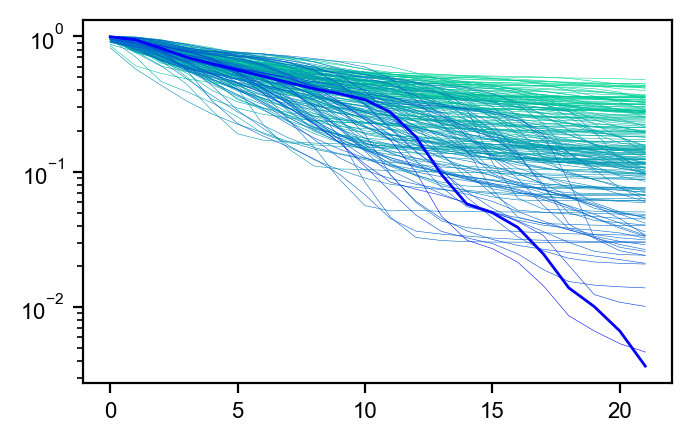

In [11]:
#We can plot the fidelities of the different parallel optimizations. 
# x axis is epoch
analysis.plot_fidelities()

In [12]:
#Can also get the "best circuit" from a loaded analysis object
best_circuit = analysis.best_circuit()
betas = best_circuit['betas']
phis = best_circuit['phis']
thetas = best_circuit['thetas']
print(best_circuit)

{'fidelity': 0.99633056, 'betas': array([-1.7633381 +1.2688829j ,  0.54475284+0.95635825j,
        0.86970407+0.54225564j,  0.40843984+0.6693694j ,
        0.5112248 +1.1590949j ,  0.4189465 -0.09396023j,
       -0.02548376-0.01854036j], dtype=complex64), 'alphas': array([0.+0.j], dtype=complex64), 'phis': array([ 0.       , -1.508267 ,  1.4179003,  1.7662199,  1.3732378,
       -1.2642595,  2.8413107], dtype=float32), 'thetas': array([ 1.5750253 , -1.3829527 ,  2.1886866 ,  0.74523187,  1.2699602 ,
       -1.3929698 , -1.6151823 ], dtype=float32)}


In [13]:
#Now, we can take the parameters found (betas, phis, and thetas)
#and use them to produce a ECD oscillator and qubit pulse.
#This requies us to specify the calibrated experimental parameters.

#The following parameters for the oscillator will be used to build the oscillator pulse.
#Here, assume that a gaussian displacement pulse to alpha=1.0 has been calibrated.
storage_params = {
        "chi_kHz": 33, #dispersive shift in kHz
        "chi_prime_Hz": 1, #second order dispersive shift in Hz
        "Ks_Hz": 0, #Kerr correction not implemented here.
        "unit_amp": 0.01, #DAC amplitude (at maximum of pulse) for gaussian displacement to alpha=1.
        "sigma": 11, #oscillator displacement pulse sigma
        "chop": 4, #oscillator displacement pulse chop (number of sigmas to include in gaussian pulse)
    }

#In a similar way, the qubit pulse parameters will be specified by a calibrated pi pulse.
#unit_amp is the DAC amplitude (at maximum of pulse) for a calibrated gaussian pi pulse, with sigma and chop specified
qubit_params = {'unit_amp': 0.5, 'sigma': 6, 'chop': 4} #parameters for qubit pi pulse.


#creating the "Fake storage" and "Fake qubit" objects which are used
#for pulse cration
storage = FakeStorage(**storage_params)
qubit = FakeQubit(**qubit_params)

#The maximum displacement used during the ECD gates.
alpha_CD = 30
#Small delay to insert between oscillator and qubit pulses to ensure timing is okay.
buffer_time = 4

In [14]:
#From these calibrations, the storage and qubit objects calculate the
#conversion between DAC amplitude, and drive amplitude in MHz.
#so, [Omega(t) in MHz] = [Omega(t) in DAC units]*Omega_m_MHz 
#and [Omega(t) in MHz] = [Omega(t) in DAC units]*Omega_m_MHz.
#These parameters also represent the maximum drive amplitude,
#since the DAC max amplitude is 1 (assuming amplifiers don't saturate.)
print('Maximum oscillator drive amplitude: |epsilon|/2*pi < %.3f MHz' % storage.epsilon_m_MHz)
print('Maximum qubit drive amplitude: |Omega|/2*pi < %.3f MHz' % qubit.Omega_m_MHz)

Maximum oscillator drive amplitude: |epsilon|/2*pi < 690.790 MHz
Maximum qubit drive amplitude: |Omega|/2*pi < 40.468 MHz


In [15]:
#generating the oscillator and qubit pulses (epsilon and Omega)
#set 'chi_prime_correction = True' to correct for linear part of chi'
#final_disp = True will implement final ECD gate as a gaussian displacement instead of full ECD gate.
#This option is useful if the qubit and oscillator are disentangled after the gate.
pulse_dict = conditional_displacement_circuit(betas, phis, thetas, storage, qubit,
                     alpha_CD,buffer_time=buffer_time, kerr_correction = False, chi_prime_correction=True, final_disp=True, pad=True)

#The dictionary will contain the pulses, in DAC units.
#Also, the displacements used for each ECD gate (the "alphas")
cavity_dac_pulse, qubit_dac_pulse,alphas = pulse_dict['cavity_dac_pulse'], pulse_dict['qubit_dac_pulse'], pulse_dict['alphas']
print('alphas:')
print(alphas)

NameError: name 'conditional_displacement_circuit' is not defined

In [ ]:
#plotting the pulse, in units of MHz. It could also be fed into a time-domain simulation.
fig, axs = plt.subplots(2,1)
axs[0].plot(np.real(storage.epsilon_m_MHz*cavity_dac_pulse))
axs[0].plot(np.imag(storage.epsilon_m_MHz*cavity_dac_pulse))
axs[1].plot(np.real(qubit.Omega_m_MHz*qubit_dac_pulse))
axs[1].plot(np.imag(qubit.Omega_m_MHz*qubit_dac_pulse))
plt.xlabel('ns')